In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['STHeiti']
mpl.rcParams['font.serif'] = ['STHeiti']
import seaborn as sns
sns.set_style("darkgrid",{"font.sans-serif":['STHeiti', 'STHeiti']})
# Set Default Encoding
import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

# 基金涨跌幅数据
▍ 先查看一下基金涨跌幅数据。

In [2]:
rate = pd.read_csv('./data/mixed_funds_rate.csv')
rate['date'] = pd.to_datetime(rate['date'])
rate.set_index('date',inplace=True)
rate.head()

,000001,000011,000017,000020,000021,000029,000031,000039,000056,000057,...,710001,710002,720001,730001,730002,740001,750001,750005,762001,770001
date,,,,,,,,,,,,,,,,,,,,,
2017-10-30,-0.57,0.31,-0.71,-0.52,-0.37,-0.61,-0.98,-1.28,-0.10,-0.13,...,-0.02,-0.08,-1.67,-1.29,-0.16,-0.96,-1.03,-0.02,-0.67,-0.33
2017-10-27,0.32,0.61,1.32,0.17,0.48,0.86,-0.11,0.99,0.25,0.78,...,-0.09,-0.09,0.45,-0.16,0.90,-0.14,0.00,0.09,-0.13,0.74
2017-10-26,0.41,-0.13,1.09,0.44,0.27,0.31,0.11,1.36,0.05,0.59,...,0.60,0.19,0.09,-0.40,0.25,0.55,-0.26,0.03,0.15,0.44
2017-10-25,0.41,0.86,0.37,1.11,0.87,0.68,0.22,-0.08,0.55,0.33,...,2.24,0.66,0.32,0.49,0.58,0.49,0.60,0.03,0.05,0.83
2017-10-24,0.25,0.79,0.00,0.27,0.11,0.25,0.22,-0.05,0.40,0.40,...,0.11,0.13,0.00,0.16,0.50,-0.07,0.17,0.15,0.26,0.33


数据为基金当天涨跌幅数据百分比，如 000001 基金 2017-10-30 的涨跌幅为 -0.57%。

▍查看全年都有数据的基金每年有多少只

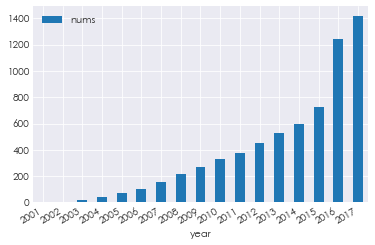

In [3]:
years = np.arange(2001,2018)
funds_nums_with_data = []
for year in years:
    data = rate[str(year)]
    max_days_with_data = data.notnull().sum().max()
    funds_nums_with_data.append((data.notnull().sum() == max_days_with_data).sum())
year_count = pd.DataFrame()
year_count['nums'] = funds_nums_with_data
year_count['year'] = years.astype(str)
year_count['year'] = pd.to_datetime(year_count['year'])
year_count.set_index('year',inplace=True)
ax = year_count.plot(kind='bar')
xtl=[item.get_text()[:4] for item in ax.get_xticklabels()]
ax.set_xticklabels(xtl)
plt.gcf().autofmt_xdate()

可以看到，国内基金的历史相对较短，近几年才出现了大量的混合型基金。考虑各方面的原因，提取后两年的数据作为基金评分的基础。

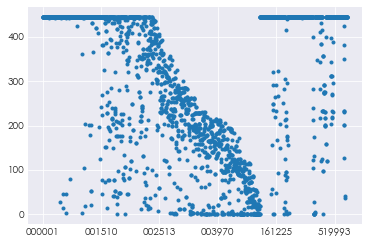

In [4]:
df = rate['2016':'2017'].dropna(how='all')
#df = rate['2017'].dropna(how='all')
df.notnull().sum().plot(ls='None',marker='.')

删除数据少于 400 个点的基金，并用 0 填充剩下的NAN。

In [5]:
df400 = df[df.columns[df.notnull().sum()>400]].fillna(0)
#df400 = df.fillna(0)
df400.sort_index(ascending=True,inplace=True)

In [6]:
df400.to_csv('data/two_years_data.csv')

# 基金评分
## 基金评分依据
参考于[5 Ways To Measure Mutual Fund Risk](https://www.investopedia.com/articles/mutualfund/112002.asp)，计算每只基金的以下参数：
* $Returns$：收益
* $Alpha$：阿尔法
* $Beta$：贝塔
* $R-Squared$：R平方
* $std$：标准差

**Note:** 非专业人士，某些参数的计算可能存在理解错误，与专业的存在差别，不过不影响数据分析练手。



***

计算收益的公式，$r_i$ 为某只基金某天的跌涨幅： 

$Returns = \prod(r_i+1)$
***
计算 $Beta$ 的公式，$\rho$ 为某基金和市场的相关系数，$\sigma_i$ 为某基金收益的标准差，$\sigma$ 为市场收益的标准差。

$Beta = \rho\cdot\frac{\sigma_i}{\sigma}$
***

计算 $Alpha$ 的公式，$r_p$ 某基金年化收益率，$r_m$ 市场年化收益率，$r_f$ 为无风险回报率，一般设为 0.03： 

$r_p -r_f = Alpha + Beta\times (r_m-r_f)$
***
计算R平方的公式：

$R\_Squared = \rho^2\times 100$
***
## 基金评分计算
### 基金跌涨幅平均值和沪深300
准备采用混合型基金的平均表现作为市场表现，先查看一下平均表现和沪深 300 的表现。

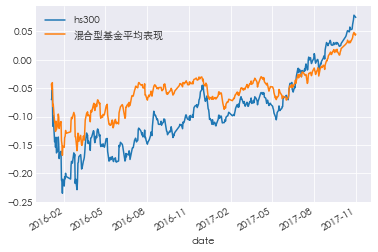

In [7]:
rm = df400.mean(axis=1)
returns_mean = (rm/100+1).cumprod()-1
hs300 = pd.read_csv('./data/hs300.csv',header=None,names={'date','hs300'})
hs300['date'] = pd.to_datetime(hs300['date'])
hs300.set_index('date',inplace=True)
hs300.sort_index(ascending=True,inplace=True)
hs_returns = (hs300/100+1).cumprod()-1
#plot the data along with the fund line
hs_returns.plot(label=u'沪深300')
returns_mean.plot(label=u'混合型基金平均表现')
plt.legend()

基本一致，就把基金的平均值当成市场表现吧。

### 年化收益
这里的收益采用上述的公式计算，并按照一年 250 个交易日换算为年收益。对所有基金2016和2017年的数据进行计算，并排名。对于基金来说，收益越高越好。

In [8]:
returns = ((df400/100+1).cumprod().ix[-1]-1)*250/len(df400)
#returns.plot(kind='hist',bins=100)
#plt.xlabel('Returns')

### Beta
Beta 表示的是某一基金相对于市场的表现情况。其绝对值越大，表示其收益变化的幅度相对市场的变化幅度越大。反映了基金对于市场变化的敏感性。例如某基金的 Beta 为 1.5，则市场变化 1% 时，基金变化 1.5%。Beta 为正，表示其走向和市场走向一致。

In [9]:
beta = {}
for code in df400.columns:
    rho = rm.corr(df400[code])
    beta[code] = rho*df400[code].std()/rm.std()    

In [10]:
beta = pd.Series(beta)
#pd.Series(beta).plot(kind='hist', bins=100)

beta 主要为两部分，一部分为 0，说明该部分基金对市场不敏感，另一部分为 1.5 左右，该部分基金的涨跌幅波动是市场的 1.5 倍。

### Alpha
Alpha 是基金的绝对回报和按照 beta 系数计算的预期回报之间的差额。Alpha 是投资者获得与市场波动无关的回报。比如投资者获得了15%的回报，其基准获得了 10% 的回报，那么 Alpha 的部分就是5%。现代金融理论认为，证券投资的额外收益率可以看做两部分之和。第一部分是和整个市场无关的，叫 alpha；第二部分是整个市场的平均收益率乘以一个 beta 系数。beta 的获取与市场走势相关，相对容易。考验本领的地方为 alpha 的获取，这是相对于市场，获得的超额收益。alpha 为正，表示获得了超过市场的超额收益，该基金的价格可能被低估，可以买入，反之亦然。

In [11]:
R_m = returns_mean.ix[-1]*250/len(df400)
r_f = 0.03
alpha = returns-r_f - pd.Series(beta)* (R_m-r_f)

In [12]:
#alpha.plot(kind='hist',bins=100)

与 Beta 相比，大部分基金没有 alpha，部分基金的整体表示还不如市场。
### R平方
R平方反映的是市场的变动对基金表现的影响。R 为 100 表示基金的表现完全受市场的影响。与 beta 的区别为，R平方表示的基金表现与市场的相关程度，beta 表示的是基金表现相对于市场的幅度。一般而言，基金的R平方值越高，其 alpha 和 beta 系数的准确性便越高。

In [13]:
r_squared = {}
for code in df400.columns:
    r_squared[code] = rm.corr(df400[code])**2*100
r_squared = pd.Series(r_squared)
#r_squared.plot(kind='hist',bins=100)

### 标准差
标准差表示基金表现的波动性，数值越小，基金越稳定。

In [14]:
std = df400.std()
#std.plot(kind='hist',bins=100)

### 数据整合

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a50fe10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10aab94d0>]], dtype=object)

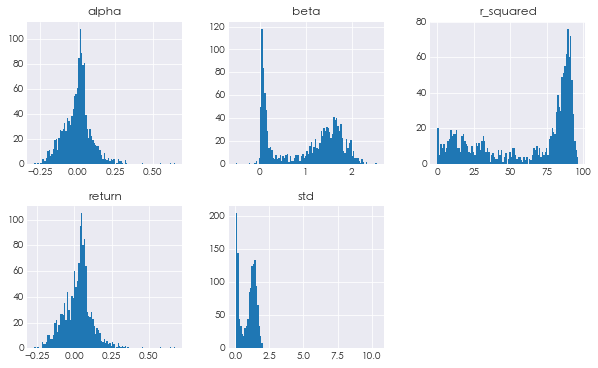

In [15]:
fund_performance = returns.to_frame()
fund_performance.columns = ['return']
fund_performance['beta'] = beta
fund_performance['alpha'] = alpha
fund_performance['r_squared'] = r_squared
fund_performance['std'] = std
fund_performance.hist(bins=100,figsize=(10,6),layout=[2,3])

# 基金分析
## 初步分析
基金的选取还是很复杂的问题，我们把问题简单化，选择的基金收益和alpha尽量高，beta大于 1，R平方在80-100，标准差尽量小。

In [16]:
fund_performance.corr()

,return,beta,alpha,r_squared,std
return,1.000000,-0.444428,0.999483,-0.396192,-0.225333
beta,-0.444428,1.000000,-0.415403,0.913072,0.804790
alpha,0.999483,-0.415403,1.000000,-0.369542,-0.199931
r_squared,-0.396192,0.913072,-0.369542,1.000000,0.680829
std,-0.225333,0.804790,-0.199931,0.680829,1.000000


可以看到，收益和alpha是高度相关的，也就是说收益高的基金，alpha也高。

In [17]:
fp = fund_performance
#  beta >1 
c_1 = fp['beta'] >1
# 80<= r_squared <100
c_2 = (fp['r_squared']>=80) & fp['r_squared']<=100
# Top 10% returns and 10% alpha
c_3 = fp['return']>fp['return'].quantile(0.9)
c_4 = fp['alpha']>fp['alpha'].quantile(0.9)
# 
good = c_1 & c_2 & c_3 & c_4 

查看一下涨跌幅的变化。

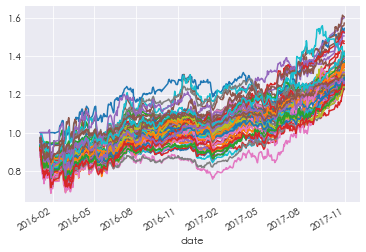

In [18]:
good_funds = fp[good]
(df400/100+1).cumprod().T[good].T.plot(legend=False)

## 分析续
70 多只基金还是有点多，需要进一步选出我们需要的基金。
查看一下每只基金上涨的天数和最终收益是否相关，并比较所有基金上涨天数和优选基金上涨天数是否有显著差别。
### 上涨天数

In [19]:
fp['up_days'] = (df400.T>0).sum(axis=1)
fp.corr()

,return,beta,alpha,r_squared,std,up_days
return,1.000000,-0.444428,0.999483,-0.396192,-0.225333,-0.050328
beta,-0.444428,1.000000,-0.415403,0.913072,0.804790,0.619095
alpha,0.999483,-0.415403,1.000000,-0.369542,-0.199931,-0.028889
r_squared,-0.396192,0.913072,-0.369542,1.000000,0.680829,0.666916
std,-0.225333,0.804790,-0.199931,0.680829,1.000000,0.518947
up_days,-0.050328,0.619095,-0.028889,0.666916,0.518947,1.000000


Text(0.5,1,u'\u6bcf\u53ea\u57fa\u91d1\u4e0a\u6da8\u5929\u6570\u5206\u5e03')

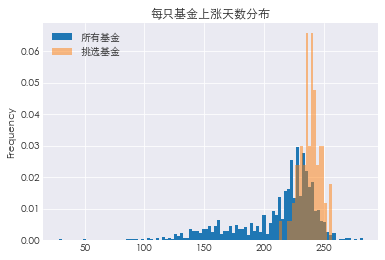

In [20]:
# plot
ax = fp['up_days'].plot(kind='hist',bins=100,label=u'所有基金',normed=True)
fp[good]['up_days'].plot(ax=ax,kind='hist',bins=20,label=u'挑选基金',normed=True,alpha=0.5)
ax.legend()
ax.set_title(u'每只基金上涨天数分布')

### 最大涨幅和最大跌幅

In [21]:
fp['max_rate'] = df400.max()
fp['min_rate'] = df400.min()
fp.corr()

,return,beta,alpha,r_squared,std,up_days,max_rate,min_rate
return,1.000000,-0.444428,0.999483,-0.396192,-0.225333,-0.050328,0.196329,0.360637
beta,-0.444428,1.000000,-0.415403,0.913072,0.804790,0.619095,0.088528,-0.824092
alpha,0.999483,-0.415403,1.000000,-0.369542,-0.199931,-0.028889,0.202535,0.336631
r_squared,-0.396192,0.913072,-0.369542,1.000000,0.680829,0.666916,0.017004,-0.752862
std,-0.225333,0.804790,-0.199931,0.680829,1.000000,0.518947,0.650071,-0.909711
up_days,-0.050328,0.619095,-0.028889,0.666916,0.518947,1.000000,0.090379,-0.548059
max_rate,0.196329,0.088528,0.202535,0.017004,0.650071,0.090379,1.000000,-0.453739
min_rate,0.360637,-0.824092,0.336631,-0.752862,-0.909711,-0.548059,-0.453739,1.000000


Text(0.5,1,u'\u6700\u5927\u8dcc\u5e45\u5206\u5e03')

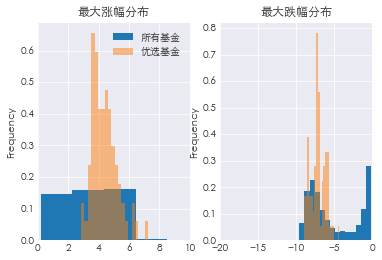

In [22]:
#plot
fig, axes = plt.subplots(nrows=1, ncols=2)
fp['max_rate'].plot(ax=axes[0],kind='hist',bins=100,label=u'所有基金',normed=True)
fp[good]['max_rate'].plot(ax=axes[0],kind='hist',bins=20,label=u'优选基金',normed=True,alpha=0.5)
axes[0].set_xlim(0,10)
axes[0].legend()
axes[0].set_title(u'最大涨幅分布')
fp['min_rate'].plot(ax=axes[1],kind='hist',bins=100,label=u'所有基金',normed=True)
fp[good]['min_rate'].plot(ax=axes[1],kind='hist',bins=20,label=u'优选基金',normed=True,alpha=0.5)
axes[1].set_xlim(-20,0)
axes[1].set_title(u'最大跌幅分布')

### Top Performing Funds
根据上面的结果来看，优选基金的上涨天数和最大涨幅与其他基金存在差别。决定选取收益、上涨天数和最大涨幅均排名前一半的基金。

In [23]:
top1 = fp[good]['up_days'] > fp[good]['up_days'].quantile(0.5)
top2 = fp[good]['max_rate'] > fp[good]['max_rate'].quantile(0.5)
top3 = fp[good]['return'] > fp[good]['return'].quantile(0.5)
top = top1 & top2 & top3

读取经理和公司数据，供参考。

In [24]:
inf = pd.read_csv('./data/mixed_funds.csv',dtype={'code':str})
inf.set_index('code',inplace=True)

In [25]:
inf_top = inf[inf.index.isin(fp[good][top].index)]
top_funds = pd.merge(fp[good][top],inf_top,left_index=True,right_index=True)

In [26]:
top_funds.sort_values(by='return',ascending=False)

,return,beta,alpha,r_squared,std,up_days,max_rate,min_rate,name,type,manager,company
180012,0.341009,1.473643,0.318029,75.041912,1.366542,247,5.03,-7.29,银华富裕主题混合,混合型,周可彦,银华基金
020026,0.323009,1.664843,0.300940,87.147779,1.432609,250,4.30,-7.50,国泰成长优选混合,混合型,申坤,国泰基金
090004,0.212675,1.318818,0.188958,84.386419,1.153270,251,4.48,-6.64,大成精选增值,混合型,李博,大成基金
160215,0.185328,1.720074,0.163522,87.802956,1.474603,241,4.57,-7.62,国泰价值经典混合(LOF),混合型,周伟锋,国泰基金
040008,0.182759,1.402632,0.159441,80.930672,1.252477,240,4.24,-7.19,华安策略优选混合,混合型,杨明,华安基金
001810,0.177559,1.259323,0.153558,80.313203,1.128824,245,4.50,-7.08,中欧潜力价值灵活配置混合,混合型,曹名长,中欧基金
020001,0.172971,1.696787,0.151054,87.359045,1.458330,240,4.24,-7.57,国泰金鹰增长灵活配置,混合型,周伟锋,国泰基金
000877,0.170283,1.333349,0.146635,85.311175,1.159641,250,4.76,-6.48,华泰柏瑞量化优选混合,混合型,田汉卿,华泰柏瑞基金


In [34]:
fp.index.name = 'code'
fp.to_csv('./data/fund_performance.csv')